In [1]:
# Train the RNN Genre Classification Model#
# Last editted by Pu Zeng, 18/10/2023 #

# Install library needed

In [2]:
!git clone https://github.com/Pu-Zeng/696-Milestone.git

Cloning into '696-Milestone'...
remote: Enumerating objects: 2986, done.
remote: Counting objects: 100% (2986/2986), done.
remote: Compressing objects: 100% (2512/2512), done.
remote: Total 2986 (delta 30), reused 2982 (delta 26), pack-reused 0
Receiving objects: 100% (2986/2986), 31.60 MiB | 12.40 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [3]:
!pip install pretty_midi
!pip install pypianoroll

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 6.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=394c31fb05e14940d7f298ce1fbfda5e05bf83f3405093fd8845040748047fec
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [4]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
# import mido
import string
import numpy as np
# from utilis import get_pianoroll_data
import pickle
from sklearn import preprocessing
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Define device
input_dir = '../Toy_Dataset/adl-piano-midi/' #Please change
output_dir = './Processed_Data/'

In [5]:
# Use our python script to preprocess the midi files into matrices
!mkdir Processed_Data
!python /content/696-Milestone/Data_Preprocessing/Piano_Genre_Classification.py /content/696-Milestone/Toy_Dataset/adl-piano-midi/ ./Processed_Data/
# It takes some time

All content numbers is 18
145it [01:26,  1.68it/s]
146it [01:05,  2.23it/s]
146it [01:11,  2.03it/s]
146it [01:04,  2.25it/s]
145it [01:08,  2.13it/s]
146it [00:57,  2.55it/s]
146it [01:02,  2.34it/s]
146it [01:05,  2.24it/s]
145it [01:02,  2.31it/s]


In [6]:
# Pick the midi files with more than 51.2s in the middle

from tqdm import tqdm
X = []
y = []
for i in tqdm(range(1,10)):
    file=open(output_dir+"music_data"+str(i)+".bin","rb")
    music_data = pickle.load(file) #保存list到文件
    file.close()
    for m in music_data:
        if m[2].shape[0]>=1012:
            X.append(m[2][500:1012,:])
            y.append(m[0])
X = np.array(X)

100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


In [7]:
# The dataset is just a toy dataset, so there are far less labels than the whole Lakh dataset, we need to drop those will few samples
X_new = []
y_new = []
X = np.array(X)
y = np.array(y)
temp_y = np.array(y)
count_y_dict = {}
for i in np.unique(temp_y):
  if (temp_y==i).sum()>=3:
    X_new = X_new + list(X[temp_y==i])
    y_new = y_new + list(y[temp_y==i])
X = np.array(X_new)
y = np.array(y_new)
num_classes = len(np.unique(y))

In [8]:
# Transform labels into one-hot variables

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

label_dict = {}
for cl in le.classes_:
    label_dict.update({cl:le.transform([cl])[0]})

# Train the model

In [9]:
# RNN Model

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.W = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x => (batch_size, seq_len, hidden_size)
        scores = self.v(torch.tanh(self.W(x))) # (batch_size, seq_len, 1)
        attention_weights = F.softmax(scores, dim=1)
        context_vector = attention_weights * x
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector, attention_weights

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(TextClassifier, self).__init__()
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, 2, dropout=0.3, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        context_vector, attention_weights = self.attention(lstm_out)
        output = self.fc(context_vector)

        return output


# from tqdm import tqdm
# cnn = TextClassifier(128, embedding_dim=128, hidden_size=1024, num_classes=17).to('cuda')

hiddenSize = 300
# Number of feature filters in second convolutional layer
numFilters = 25
# Dropout rate
dropoutRate = 0.3
# Activation function
activation = "ReLU"
# Learning rate
learningRate = 0.01
# Momentum for SGD optimizer
momentum = 0.9
# Number of training epochs
numEpochs = 30

In [10]:
# Train and Validation function

from tqdm import tqdm
def train_epoch(cnn,device,dataloader,loss_fn,optimizer):
    cnn.train()
    cnnRunningLoss = 0
    total = 0
    R2 = 0
    cnnCorrect=0
    total1=0
    for i, (inputs, labels) in enumerate(dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(device).reshape(-1,512,128)

        labels = labels.to(device)
        # Forward propagation
        cnnOutputs = cnn(inputs)
        # print(cnnOutputs.shape)
        l2_lambda = 0.005
        l2_reg = torch.tensor(0.).to(device)
        for param in cnn.parameters():
            l2_reg += torch.norm(param)
        # Backpropagation
        cnnLoss = criterion(cnnOutputs, labels)+l2_reg*l2_lambda
        cnnLoss.backward()
        # Gradient update
        optimizer.step()
        total += 1
        total1+=labels.size(0)
        cnnRunningLoss += cnnLoss.item()
        _, cnnPredicted = torch.max(cnnOutputs.data, 1)
        cnnCorrect += (cnnPredicted == labels).sum().item()
    return cnnRunningLoss/total, cnnCorrect/total1

def valid_epoch(cnn,device,dataloader,loss_fn):
    cnn.eval()
    totalLoss = 0
    total = 0
    total1 = 0
    R2 = 0
    cnnLoss = 0
    cnnCorrect=0
    for inputs, labels in dataloader:
        inputs = inputs.to(device).reshape(-1,512,128)
        labels = labels.to(device)
        cnnOutputs = cnn(inputs)
        cnnLoss = criterion(cnnOutputs, labels)
        _, cnnPredicted = torch.max(cnnOutputs.data, 1)
        total += labels.size(0)
        total1 +=1
        totalLoss += cnnLoss.item()
        cnnCorrect += (cnnPredicted == labels).sum().item()
    accuracy = cnnCorrect / total
    cnn.train()
    return totalLoss/total1, accuracy

In [11]:
# Train the model

import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y) #First split, so there is no data leakage problems

# Transform data into DataSet
X_train_v = torch.as_tensor(X_train_v, dtype=torch.float) # an alternative to torch.from_numpy
y_train_v = torch.as_tensor(y_train_v, dtype=torch.float)
X_test = torch.as_tensor(X_test, dtype=torch.float)
y_test = torch.as_tensor(y_test, dtype=torch.float)
splits=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
train_dataset = TensorDataset(X_train_v, y_train_v)
test_dataset = TensorDataset(X_test, y_test)
batch_size=128
models = []
history = {'fold':[], 'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

#K-Fold validation
for fold, (train_idx,val_idx) in enumerate(splits.split(X_train_v,y_train_v)):
    print('Fold {}'.format(fold + 1))
    t = pd.DataFrame(y_train_v[train_idx], columns = ['class']).reset_index()
    idx = []
    y_train = []
    #Resampling to solve the unbalanced problem
    for i in range(0,num_classes):
        # if i!=label_dict['Unknown']:
      idx += list(t[t['class']==i].sample(500,replace=True)['index'])
      y_train += [i]*500
    X_train = X_train_v[train_idx][idx]

    t = pd.DataFrame(y_train_v[val_idx], columns = ['class']).reset_index()
    idx = []
    y_val = []
    for i in range(0,num_classes):
        # if i!=label_dict['Unknown']:
      idx += list(t[t['class']==i].sample(20,replace=True)['index'])
      y_val += [i]*20
    X_val =  X_train_v[val_idx][idx]

    X_train = torch.as_tensor(X_train, dtype=torch.float) # an alternative to torch.from_numpy
    y_train = torch.as_tensor(y_train, dtype=torch.float).type(torch.LongTensor)
    X_val = torch.as_tensor(X_val, dtype=torch.float)
    y_val = torch.as_tensor(y_val, dtype=torch.float).type(torch.LongTensor)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_val, y_val)

    from torch.utils.data import Dataset, DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = TextClassifier(128, embedding_dim=128, hidden_size=1024, num_classes=18).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(list(model.parameters()), lr=learningRate, momentum=momentum)
    # optimizer = torch.optim.Adam(list(model.parameters()), lr=learningRate)
    best_test = -np.inf
    best_model = None

    #Train the model
    for epoch in range(numEpochs):
        train_loss, train_R2=train_epoch(model,device,train_dataloader,criterion,optimizer)
        test_loss, test_R2=valid_epoch(model,device,test_dataloader,criterion)
        history['fold'].append(fold)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_R2)
        history['test_acc'].append(test_R2)
        if test_R2>best_test:
            test_test = test_R2
            best_model = model
        print('Train Loss: {}, Train_acc: {}, Test Loss: {}, Test acc: {}'.format(train_loss, train_R2, test_loss, test_R2))
    models.append([best_model])

Fold 1
Train Loss: 3.526208555788026, Train_acc: 0.4791764705882353, Test Loss: 2.7203493172472175, Test acc: 0.45
Train Loss: 2.092148676850742, Train_acc: 0.8694117647058823, Test Loss: 2.860736299644817, Test acc: 0.5441176470588235
Train Loss: 1.8168844665799821, Train_acc: 0.9435294117647058, Test Loss: 2.8987612913955343, Test acc: 0.6
Train Loss: 1.7289851608132958, Train_acc: 0.9683529411764706, Test Loss: 3.282356630672108, Test acc: 0.6176470588235294
Train Loss: 1.680644561025433, Train_acc: 0.975764705882353, Test Loss: 3.3571246564388275, Test acc: 0.6176470588235294
Train Loss: 1.6674337454308243, Train_acc: 0.975764705882353, Test Loss: 3.386651106856086, Test acc: 0.611764705882353
Train Loss: 1.6554375331204636, Train_acc: 0.9754117647058823, Test Loss: 3.396113959225741, Test acc: 0.611764705882353
Train Loss: 1.644053226126764, Train_acc: 0.975764705882353, Test Loss: 3.3876565125855533, Test acc: 0.611764705882353
Train Loss: 1.6329867705366665, Train_acc: 0.9757647

KeyboardInterrupt: ignored

# Evaluation

In [12]:
models=[[best_model]]

In [13]:
#Calculate the average accuray of the 5 models
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
t = pd.DataFrame(y_test, columns = ['class']).reset_index()
criterion = nn.CrossEntropyLoss()
idx = []
y_test = []
for i in range(0,num_classes):
    # if i!=label_dict['Unknown']:
    idx += list(t[t['class']==i].sample(20,replace=True)['index'])
    y_test += [i]*20
X_test =  X_test[idx]
X_test = torch.as_tensor(X_test, dtype=torch.float)
y_test = torch.as_tensor(y_test, dtype=torch.float).type(torch.LongTensor)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
acc = []
for best_model in models:
  acc.append(valid_epoch(best_model[0],device,test_dataloader,criterion)[1])

In [14]:
np.mean(acc)

0.6647058823529411

In [15]:
# Calculate the accuracy with majority vote

outputs = []
with torch.no_grad():
  for model in models:
    model[0].eval()
    model_output = []
    label_= []
    model[0].to(device)
    for inputs, labels in test_dataloader:
        inputs = inputs.reshape(-1,512,128).to(device)
        labels = labels.to(device)
        cnnOutputs = model[0](inputs)
        model_output.append(cnnOutputs)
        label_.append(labels)
        # del inputs
    outputs.append(torch.vstack(model_output))

66.47058823529412


<Axes: >

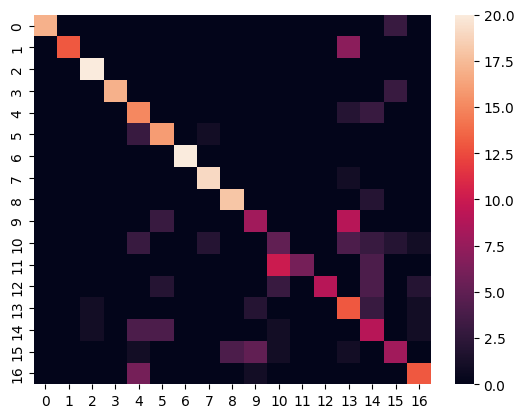

In [16]:
shape = outputs[0].shape
labels = torch.hstack(label_)
cnnresult = torch.vstack(outputs).reshape(-1,shape[0],shape[1]).mean(axis=0).to('cpu')
_, cnnPredicted = torch.max(cnnresult.data, 1)
cnnCorrect = (cnnPredicted.detach().numpy() == labels.to('cpu').detach().numpy()).sum().item()
print(cnnCorrect/len(labels)*100)
from sklearn.metrics import confusion_matrix
confu_m = confusion_matrix(labels.to('cpu'), cnnPredicted.to('cpu'))
import seaborn as sns
sns.heatmap(confu_m,square=False)

In [18]:
# Show the Precision, Recall, F1 scores of each classes
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
scores = pd.DataFrame(precision_recall_fscore_support(cnnPredicted.to('cpu'), labels.to('cpu'), labels = list(range(num_classes))),index=['precision','recall','f1','support'], columns = list(label_dict)[:num_classes])
scores

,Ambient,Blues,Children,Classical,Country,Electronic,Folk,Jazz,Latin,Pop,Rap,Reggae,Religious,Rock,Soul,Soundtracks,World
precision,0.850000,0.650000,1.000000,0.850000,0.750000,0.800000,1.0,0.950000,0.900000,0.400000,0.25,0.300000,0.45000,0.650000,0.450000,0.400000,0.650000
recall,1.000000,1.000000,0.909091,1.000000,0.468750,0.640000,1.0,0.863636,0.818182,0.500000,0.25,1.000000,1.00000,0.351351,0.321429,0.500000,0.722222
f1,0.918919,0.787879,0.952381,0.918919,0.576923,0.711111,1.0,0.904762,0.857143,0.444444,0.25,0.461538,0.62069,0.456140,0.375000,0.444444,0.684211
support,17.000000,13.000000,22.000000,17.000000,32.000000,25.000000,20.0,22.000000,22.000000,16.000000,20.00,6.000000,9.00000,37.000000,28.000000,16.000000,18.000000


In [19]:
# Print the label_dict
label_dict = {}
for cl in le.classes_:
    label_dict.update({cl:le.transform([cl])[0]})
label_dict

{'Ambient': 0,
 'Blues': 1,
 'Children': 2,
 'Classical': 3,
 'Country': 4,
 'Electronic': 5,
 'Folk': 6,
 'Jazz': 7,
 'Latin': 8,
 'Pop': 9,
 'Rap': 10,
 'Reggae': 11,
 'Religious': 12,
 'Rock': 13,
 'Soul': 14,
 'Soundtracks': 15,
 'World': 16}